<a href="https://colab.research.google.com/github/Polimolina/METEO/blob/main/Copia_de_Investigaci%C3%B3n_bases_datos_meteosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook de pruebas para datos meteo de predicción nacional mediante meteosat. https://dev.meteostat.net/

Este notebook está sólo dedicado a preparar el código para:
Conectarnos a los datos históricos de METEOSAT y/o la API de METEOSAT, ver los datos, decidir qué datos queremos y cómo los queremos representar. Si podemos, aprender también a visualizar los datos de manera interactiva.


Me bajo librerias para visualizar datos

In [1]:
!pip install matplotlib
!pip install matplotlib seaborn folium meteostat pandas

Y la de meteostat

In [2]:
pip install meteostat

Le pregunto por todas las estaciones cercanas a Madrid para ver qué un ejemplo de número de estaciones disponibles por ciudad.Pongo 10,50,100 y voy probando. Veo que cada estación empezó y quizá, dejó de funcionar en una determinada fecha diferente de los demás, no sé si esto será un problema para luego poner rangos amplios de fechas.

In [3]:
from meteostat import Stations

# Obtener estaciones cercanas a Madrid, España (40.4168, -3.7038)
stations = Stations()
stations = stations.nearby(40.4168, -3.7038)  # Cambia a tus coordenadas deseadas
station = stations.fetch(50)  # Obtener las 50 estaciones más cercanas

# Mostrar estaciones encontradas
print(station)


                                      name country region    wmo  icao  \
id                                                                       
08222                               Madrid      ES      M  08222  <NA>   
08223              Madrid / Cuatro Vientos      ES      M  08223  LEVS   
08224                      Madrid / Getafe      ES      M  08224  LEGT   
08221                     Madrid / Barajas      ES      M  08221  LEMD   
LEMM0           Madrid / Barajas de Madrid      ES      M   <NA>  LEMM   
08227                    Madrid / Torrejon      ES      M  08227  LETO   
08219                       Madri-Colmenar      ES      M  08219  LECV   
08215                          Navacerrada      ES     CL  08215  <NA>   
08226                          Guadalajara      ES     CM  08226  <NA>   
08272                               Toledo      ES     CM  08272  <NA>   
08213                              Segovia      ES     CL  08213  <NA>   
08210                                A

Ahora pregunto por todas las ciudades de España, con fechas concretas, como por ejemplo del 20 al 27 de febrero del 2024, a ver que sale. Veo que si amplío mucho las fechas, a varios años por ejemplo, el código da error. Habría que meter algo más de código para que obviase las columnas vacías.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 12.1 MB/s eta 0:00:00


2025-03-03 11:55:03.480 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-02-20   9.8   5.7  18.8   0.0   NaN  357.0   7.6   NaN  1030.6   NaN   
2024-02-21   9.6   6.1  15.3   0.0   NaN  275.0   9.5   NaN  1025.9   NaN   
2024-02-22  10.3   7.7  12.6   4.5   NaN  244.0  23.2   NaN  1016.2   NaN   
2024-02-23   5.9   4.1   9.6   0.2   NaN  260.0  20.2   NaN  1013.1   NaN   
2024-02-24   5.9   3.4  10.3   0.0   NaN  274.0  20.3   NaN  1014.5   NaN   

            ciudad      lat     lon  
2024-02-20  Madrid  40.4168 -3.7038  
2024-02-21  Madrid  40.4168 -3.7038  
2024-02-22  Madrid  40.4168 -3.7038  
2024-02-23  Madrid  40.4168 -3.7038  
2024-02-24  Madrid  40.4168 -3.7038  


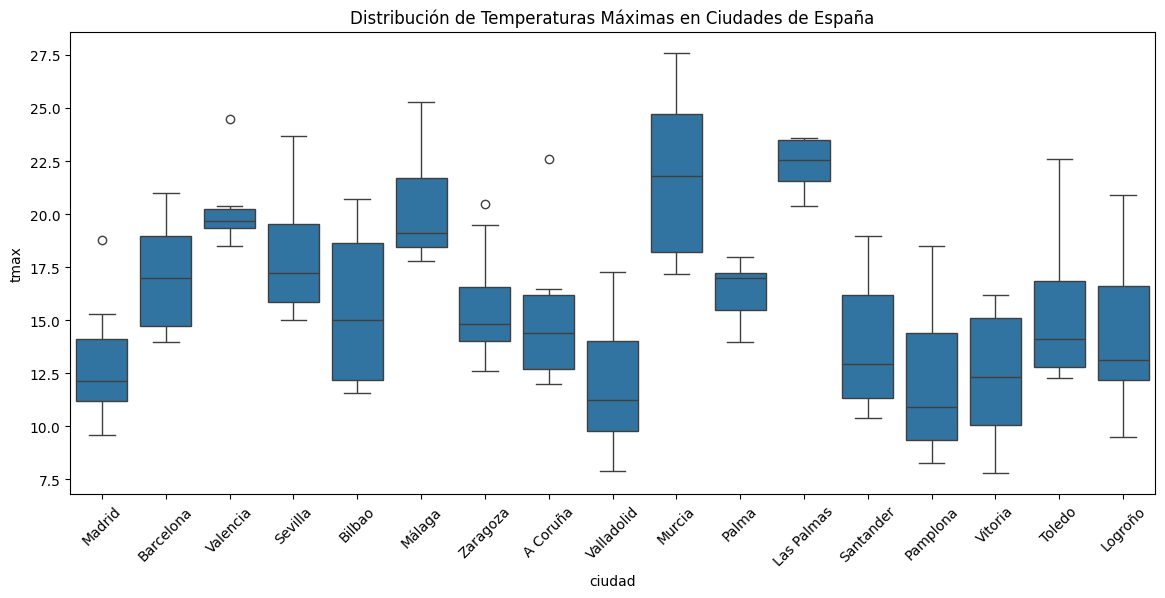

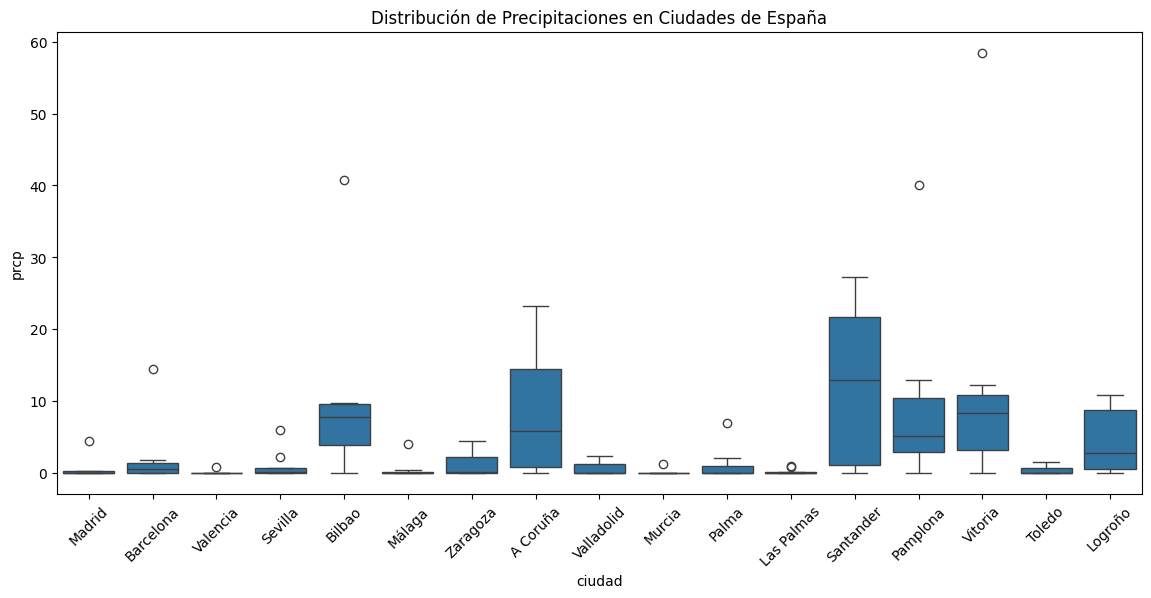

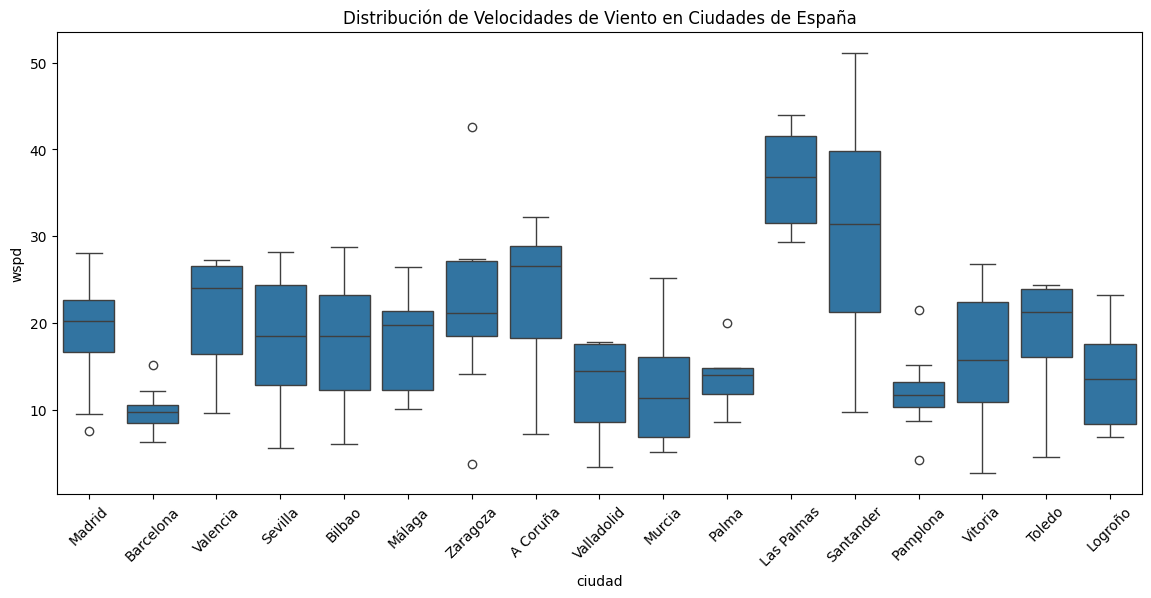

Mapa guardado como mapa_alertas_espana.html


In [4]:
!pip install streamlit
!pip install streamlit-folium
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
from IPython.display import display, HTML
from meteostat import Daily, Stations, Point
from datetime import datetime
import streamlit as st
from streamlit_folium import folium_static

# Lista de puntos geográficos (coordenadas aproximadas de ciudades importantes)
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3874, 2.1686),
    "Valencia": (39.4699, -0.3763),
    "Sevilla": (37.3886, -5.9823),
    "Bilbao": (43.2630, -2.9340),
    "Málaga": (36.7202, -4.4203),
    "Zaragoza": (41.6488, -0.8891),
    "A Coruña": (43.3623, -8.4115),
    "Valladolid": (41.6528, -4.7245),
    "Murcia": (37.9922, -1.1307),
    "Palma": (39.5696, 2.6502),
    "Las Palmas": (28.1235, -15.4363),
    "Santa Cruz de Tenerife": (28.4636, -16.2518),
    "Santander": (43.4623, -3.8099),
    "Pamplona": (42.8125, -1.6458),
    "Vitoria": (42.8467, -2.6716),
    "Toledo": (39.8628, -4.0273),
    "Logroño": (42.4650, -2.4480)
}

# Crear DataFrame vacío para consolidar datos de toda España
df_total = pd.DataFrame()

# Definir periodo de tiempo
start = datetime(2024, 2, 20)
end = datetime(2024, 2, 27)

# Recorrer ciudades y obtener datos
for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()
    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# Mostrar datos combinados
print(df_total.head())

# Gráfico de temperaturas máximas por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='tmax', data=df_total)
plt.title('Distribución de Temperaturas Máximas en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de precipitaciones por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='prcp', data=df_total)
plt.title('Distribución de Precipitaciones en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de velocidades de viento por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='wspd', data=df_total)
plt.title('Distribución de Velocidades de Viento en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Detección de alertas/emergencias
df_total['emergencia_viento'] = df_total['wspd'] > 80

# Definir alerta por lluvia fuerte
df_total['emergencia_lluvia'] = df_total['prcp'] > 50

# Crear mapa con alertas visuales
m = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

for _, row in df_total.iterrows():
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(f"Ciudad: {row['ciudad']}\nFecha: {row.name.date()}\n"
               f"Temp Max: {row['tmax']}°C\nPrecip: {row['prcp']} mm\nViento: {row['wspd']} km/h")
    ).add_to(m)

m.save("mapa_alertas_espana.html")
print("Mapa guardado como mapa_alertas_espana.html")
display(HTML('<iframe src="mapa_alertas_espana.html" width="100%" height="600"></iframe>'))


Los parametros genrial pero no veo alertas. Parece que ha generado una html, así que hay que generar con flask una url o usar la herramienta que nos dio Eva. De mometno voy a ver qué datos hay en la BD meteosat.



In [5]:
# Verificar las primeras filas del DataFrame y las columnas
print(df_total.columns)
print(df_total.head())


Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'ciudad', 'lat', 'lon', 'emergencia_viento',
       'emergencia_lluvia'],
      dtype='object')
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-02-20   9.8   5.7  18.8   0.0   NaN  357.0   7.6   NaN  1030.6   NaN   
2024-02-21   9.6   6.1  15.3   0.0   NaN  275.0   9.5   NaN  1025.9   NaN   
2024-02-22  10.3   7.7  12.6   4.5   NaN  244.0  23.2   NaN  1016.2   NaN   
2024-02-23   5.9   4.1   9.6   0.2   NaN  260.0  20.2   NaN  1013.1   NaN   
2024-02-24   5.9   3.4  10.3   0.0   NaN  274.0  20.3   NaN  1014.5   NaN   

            ciudad      lat     lon  emergencia_viento  emergencia_lluvia  
2024-02-20  Madrid  40.4168 -3.7038              False              False  
2024-02-21  Madrid  40.4168 -3.7038              False              False  
2024-02-22  Madrid  40.4168 -3.7038              False              False  
2024-02-23  Madrid  40.4168 -3.7038        

Vale, hay emergencias viento y lluvia, y datos temp, prcp, snow, pres...Podemos hacer muchas cosas. De momento voy a probar la API KEY, a ver qué pasa.

Y ahora voy a usar la API KEY, a ver qué sale. Si lo ejecutáis os va a pedir una clave. Es gratis hasta 500 llamadas al mes.

Introduce tu METEOSAT API Key: 757dfe0f9amsh36c67c1ce2418b0p10bfcdjsn9212c2217d5e


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-02-20   9.8   5.7  18.8   0.0   NaN  357.0   7.6   NaN  1030.6   NaN   
2024-02-21   9.6   6.1  15.3   0.0   NaN  275.0   9.5   NaN  1025.9   NaN   
2024-02-22  10.3   7.7  12.6   4.5   NaN  244.0  23.2   NaN  1016.2   NaN   
2024-02-23   5.9   4.1   9.6   0.2   NaN  260.0  20.2   NaN  1013.1   NaN   
2024-02-24   5.9   3.4  10.3   0.0   NaN  274.0  20.3   NaN  1014.5   NaN   

            ciudad      lat     lon  
2024-02-20  Madrid  40.4168 -3.7038  
2024-02-21  Madrid  40.4168 -3.7038  
2024-02-22  Madrid  40.4168 -3.7038  
2024-02-23  Madrid  40.4168 -3.7038  
2024-02-24  Madrid  40.4168 -3.7038  


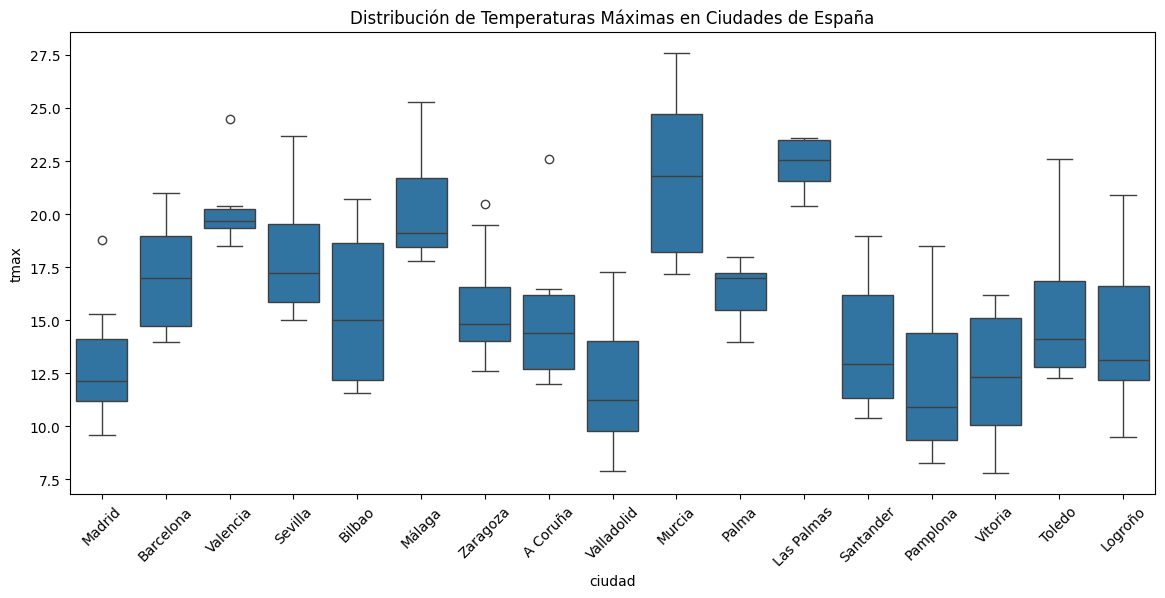

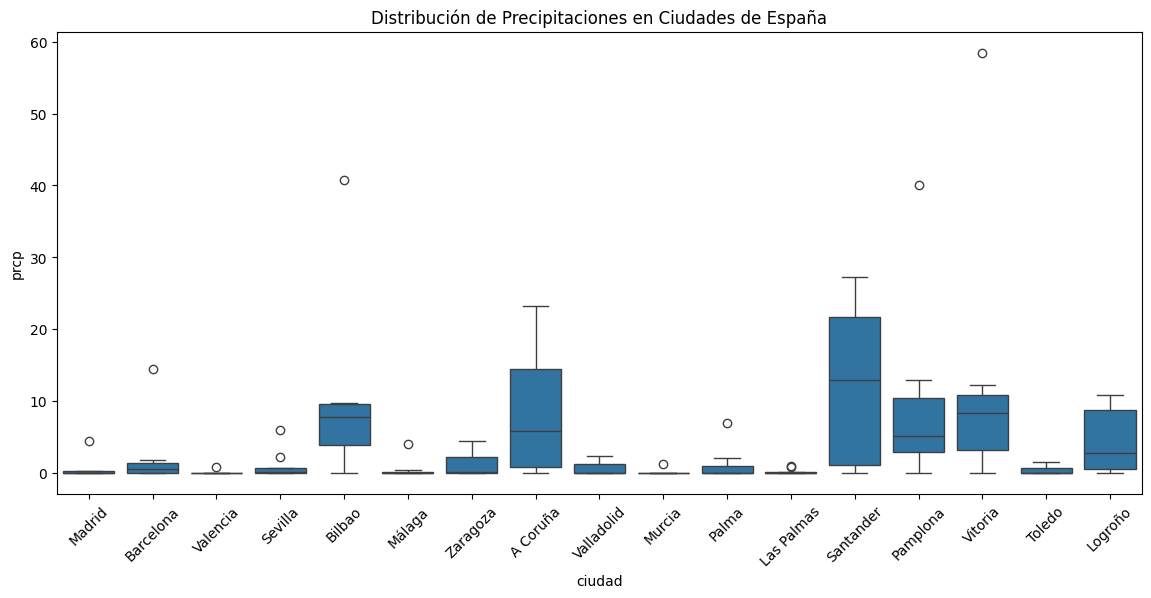

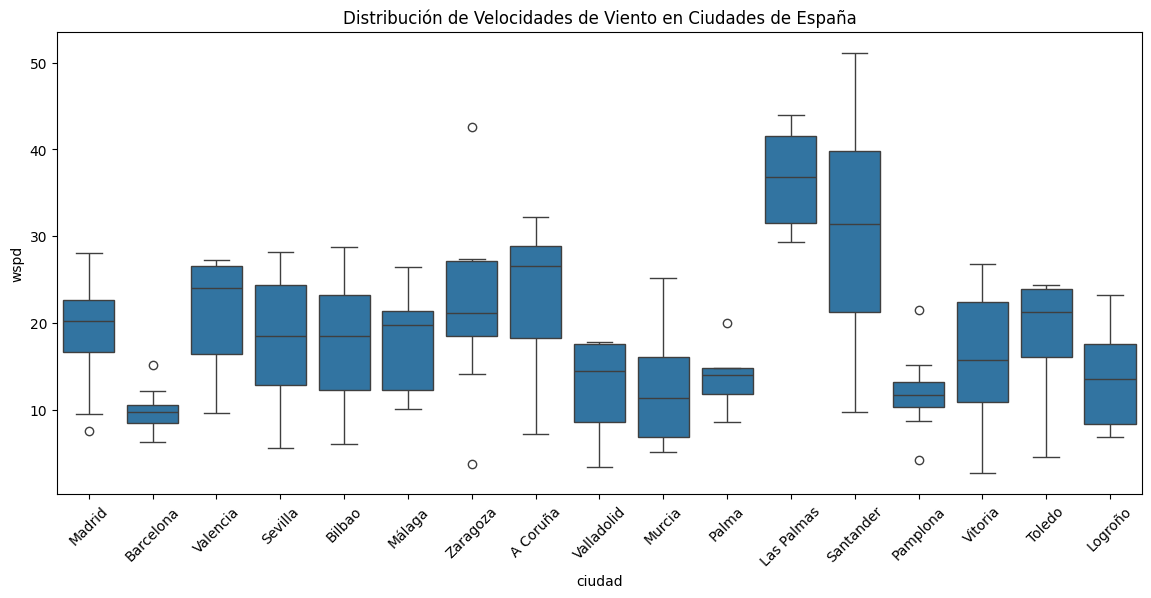

Mapa guardado como mapa_alertas_espana.html


In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
from IPython.display import display, HTML
from meteostat import Daily, Stations, Point
from datetime import datetime
import streamlit as st
from streamlit_folium import folium_static
import os

# --- SOLICITAR API KEY AL USUARIO ---
API_KEY = input("Introduce tu METEOSAT API Key:")
os.environ['METEOSAT_API_KEY'] = API_KEY  # Opcional: la almacena temporalmente en el entorno

# Lista de puntos geográficos (coordenadas aproximadas de ciudades importantes)
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3874, 2.1686),
    "Valencia": (39.4699, -0.3763),
    "Sevilla": (37.3886, -5.9823),
    "Bilbao": (43.2630, -2.9340),
    "Málaga": (36.7202, -4.4203),
    "Zaragoza": (41.6488, -0.8891),
    "A Coruña": (43.3623, -8.4115),
    "Valladolid": (41.6528, -4.7245),
    "Murcia": (37.9922, -1.1307),
    "Palma": (39.5696, 2.6502),
    "Las Palmas": (28.1235, -15.4363),
    "Santa Cruz de Tenerife": (28.4636, -16.2518),
    "Santander": (43.4623, -3.8099),
    "Pamplona": (42.8125, -1.6458),
    "Vitoria": (42.8467, -2.6716),
    "Toledo": (39.8628, -4.0273),
    "Logroño": (42.4650, -2.4480)
}

# Crear DataFrame vacío para consolidar datos de toda España
df_total = pd.DataFrame()

# Definir periodo de tiempo
start = datetime(2024, 2, 20)
end = datetime(2024, 2, 27)

# Recorrer ciudades y obtener datos
for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])

    # Aquí Meteostat usa automáticamente la API Key de la variable de entorno, si es necesario
    data = Daily(point, start, end).fetch()

    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# Mostrar datos combinados
print(df_total.head())

# Gráfico de temperaturas máximas por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='tmax', data=df_total)
plt.title('Distribución de Temperaturas Máximas en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de precipitaciones por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='prcp', data=df_total)
plt.title('Distribución de Precipitaciones en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de velocidades de viento por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='wspd', data=df_total)
plt.title('Distribución de Velocidades de Viento en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Detección de alertas/emergencias
df_total['emergencia_viento'] = df_total['wspd'] > 80

# Definir alerta por lluvia fuerte
df_total['emergencia_lluvia'] = df_total['prcp'] > 50

# Crear mapa con alertas visuales
m = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

for _, row in df_total.iterrows():
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(f"Ciudad: {row['ciudad']}\nFecha: {row.name.date()}\n"
               f"Temp Max: {row['tmax']}°C\nPrecip: {row['prcp']} mm\nViento: {row['wspd']} km/h")
    ).add_to(m)

m.save("mapa_alertas_espana.html")
print("Mapa guardado como mapa_alertas_espana.html")
display(HTML('<iframe src="mapa_alertas_espana.html" width="100%" height="600"></iframe>'))


Y ahora pruebo en Octubre del 2024, a ver si vemos la DANA

Columnas disponibles: Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'ciudad', 'lat', 'lon'],
      dtype='object')
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-10-01  20.1  13.5  26.9   0.0   NaN  236.0   9.7   NaN  1016.2   NaN   
2024-10-02  20.8  16.8  25.8   1.1   NaN  259.0  17.0   NaN  1012.3   NaN   
2024-10-03  19.4  14.3  24.8   0.0   NaN  349.0  12.7   NaN  1012.8   NaN   
2024-10-04  17.6  10.9  25.1   0.0   NaN   21.0   7.8   NaN  1014.8   NaN   
2024-10-05  18.9  12.8  25.4   0.0   NaN  295.0  11.3   NaN  1013.7   NaN   

            ciudad      lat     lon  
2024-10-01  Madrid  40.4168 -3.7038  
2024-10-02  Madrid  40.4168 -3.7038  
2024-10-03  Madrid  40.4168 -3.7038  
2024-10-04  Madrid  40.4168 -3.7038  
2024-10-05  Madrid  40.4168 -3.7038  


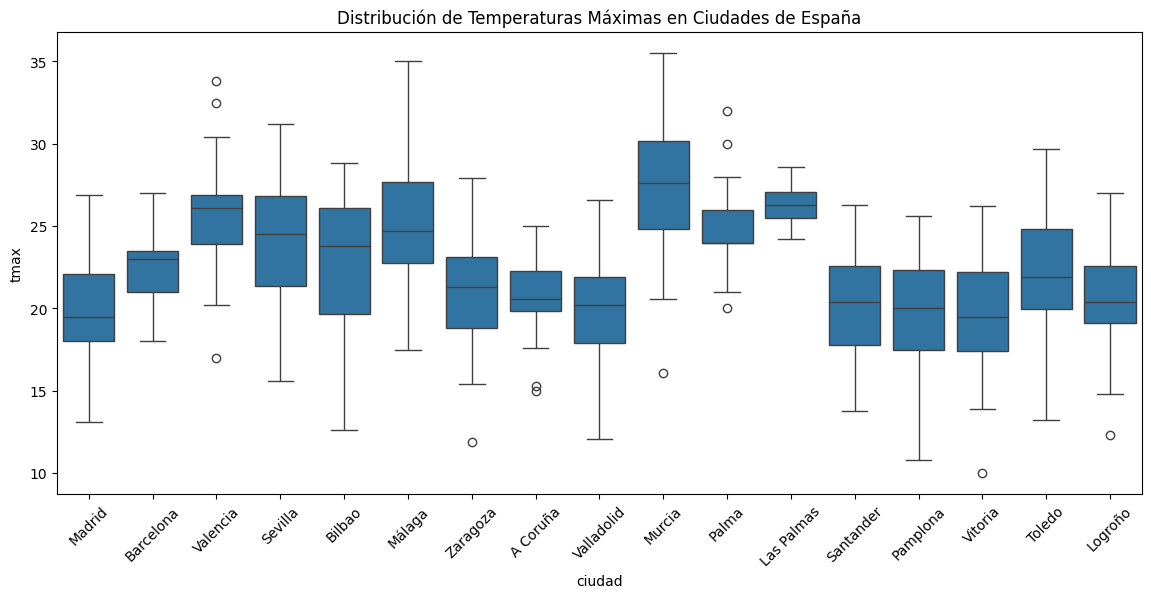

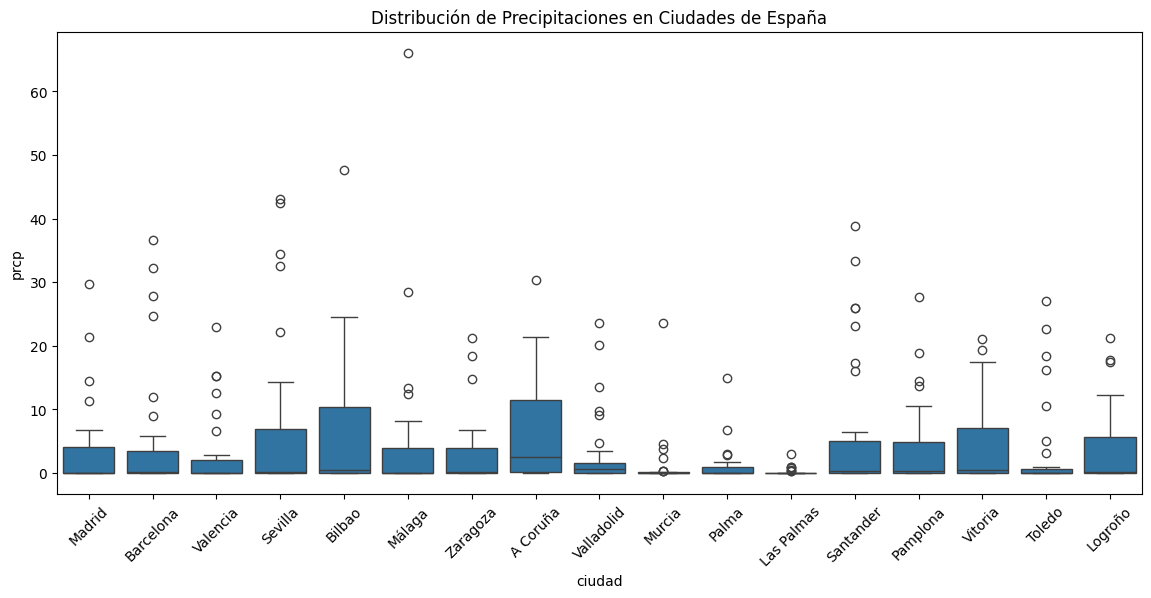

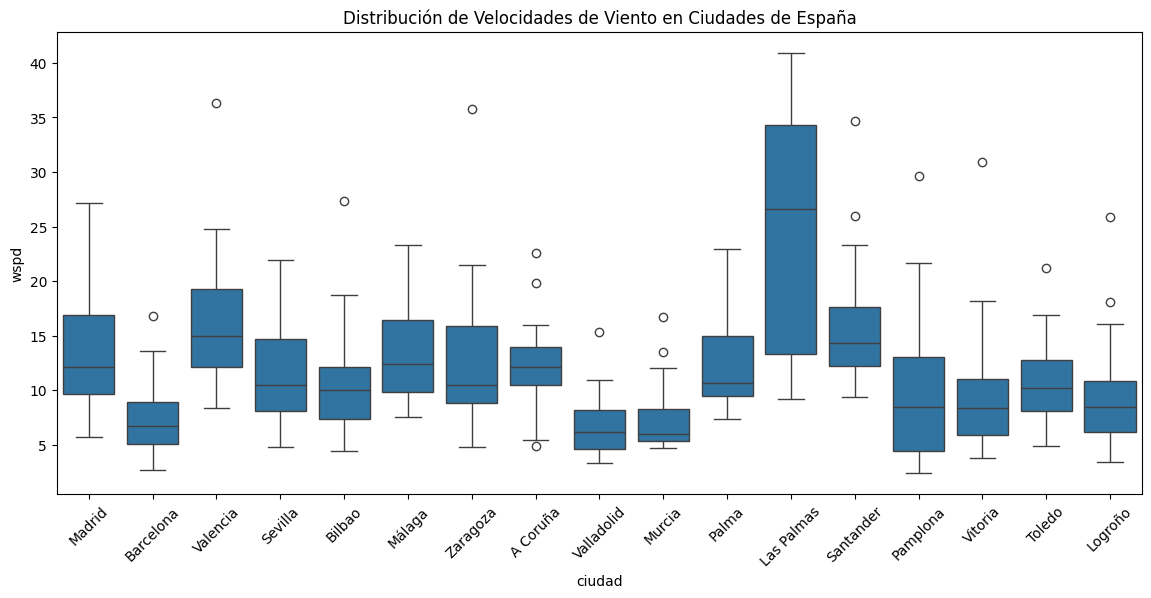

In [7]:
# Instalar librerías necesarias (ejecuta estas líneas solo si no las tienes ya)
# !pip install meteostat folium seaborn matplotlib pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import IFrame
from datetime import datetime
from meteostat import Point, Daily
from IPython.display import display, IFrame as DisplayIFrame, HTML

# Lista de ciudades con coordenadas
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3874, 2.1686),
    "Valencia": (39.4699, -0.3763),
    "Sevilla": (37.3886, -5.9823),
    "Bilbao": (43.2630, -2.9340),
    "Málaga": (36.7202, -4.4203),
    "Zaragoza": (41.6488, -0.8891),
    "A Coruña": (43.3623, -8.4115),
    "Valladolid": (41.6528, -4.7245),
    "Murcia": (37.9922, -1.1307),
    "Palma": (39.5696, 2.6502),
    "Las Palmas": (28.1235, -15.4363),
    "Santa Cruz de Tenerife": (28.4636, -16.2518),
    "Santander": (43.4623, -3.8099),
    "Pamplona": (42.8125, -1.6458),
    "Vitoria": (42.8467, -2.6716),
    "Toledo": (39.8628, -4.0273),
    "Logroño": (42.4650, -2.4480)
}

# Definir el periodo de tiempo
start = datetime(2024, 10, 1)
end = datetime(2024, 10, 31)

# DataFrame para consolidar datos de todas las ciudades
df_total = pd.DataFrame()

# Recorrer cada ciudad y obtener sus datos climáticos
for ciudad, (lat, lon) in ciudades.items():
    punto = Point(lat, lon)
    datos_ciudad = Daily(punto, start, end).fetch()

    # Añadir columna con el nombre de la ciudad y coordenadas
    datos_ciudad['ciudad'] = ciudad
    datos_ciudad['lat'] = lat
    datos_ciudad['lon'] = lon

    # Unir al DataFrame general
    df_total = pd.concat([df_total, datos_ciudad])

# Mostrar primeras filas y columnas disponibles para revisar
print("Columnas disponibles:", df_total.columns)
print(df_total.head())

# Definir alertas (puedes ajustar los umbrales según el caso)
df_total['emergencia_viento'] = df_total['wspd'] > 50    # Alerta por viento fuerte
df_total['emergencia_lluvia'] = df_total['prcp'] > 30    # Alerta por lluvia fuerte

# Gráfico de temperaturas máximas por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='tmax', data=df_total)
plt.title('Distribución de Temperaturas Máximas en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de precipitaciones por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='prcp', data=df_total)
plt.title('Distribución de Precipitaciones en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de velocidades de viento por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='wspd', data=df_total)
plt.title('Distribución de Velocidades de Viento en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Crear mapa con alertas
m = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

for _, row in df_total.iterrows():
    # Definir color según tipo de alerta
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    # Añadir un marcador circular en el mapa
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"<b>Ciudad:</b> {row['ciudad']}<br>"
            f"<b>Fecha:</b> {row.name.date()}<br>"
            f"<b>Temp Máx:</b> {row['tmax']}°C<br>"
            f"<b>Precipitación:</b> {row['prcp']} mm<br>"
            f"<b>Viento:</b> {row['wspd']} km/h<br>"
            f"<b>Alerta:</b> {'Viento fuerte' if row['emergencia_viento'] else 'Lluvia intensa' if row['emergencia_lluvia'] else 'Ninguna'}"
        )
    ).add_to(m)

# Guardar el mapa
m.save("mapa_alertas_espana.html")

# Mostrar el mapa en un IFrame
display(HTML('<h3>Mapa de Alertas Meteorológicas</h3>'))
display(DisplayIFrame("mapa_alertas_espana.html", width="100%", height="600"))


Intento ver las alertas de Valencia en Octubre 2024

Columnas disponibles: Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'ciudad', 'lat', 'lon'],
      dtype='object')
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
time                                                                        
2024-10-01  20.2  17.0  26.2   0.0   NaN  324.0  11.6   NaN  1015.6   NaN   
2024-10-02  23.9  18.8  32.5   0.0   NaN  281.0  18.0   NaN  1009.3   NaN   
2024-10-03  22.2  21.2  26.8   0.0   NaN   27.0  17.6   NaN  1009.3   NaN   
2024-10-04  19.1  16.0  26.4   0.0   NaN  279.0  13.9   NaN  1013.4   NaN   
2024-10-05  19.7  15.8  27.0   0.0   NaN  332.0  13.8   NaN  1012.9   NaN   

              ciudad      lat     lon  
time                                   
2024-10-01  Valencia  39.4699 -0.3763  
2024-10-02  Valencia  39.4699 -0.3763  
2024-10-03  Valencia  39.4699 -0.3763  
2024-10-04  Valencia  39.4699 -0.3763  
2024-10-05  Valencia  39.4699 -0.3763  


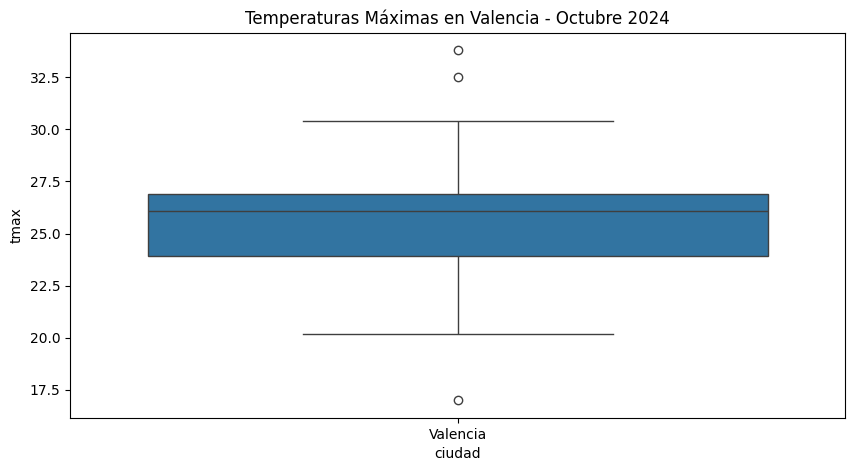

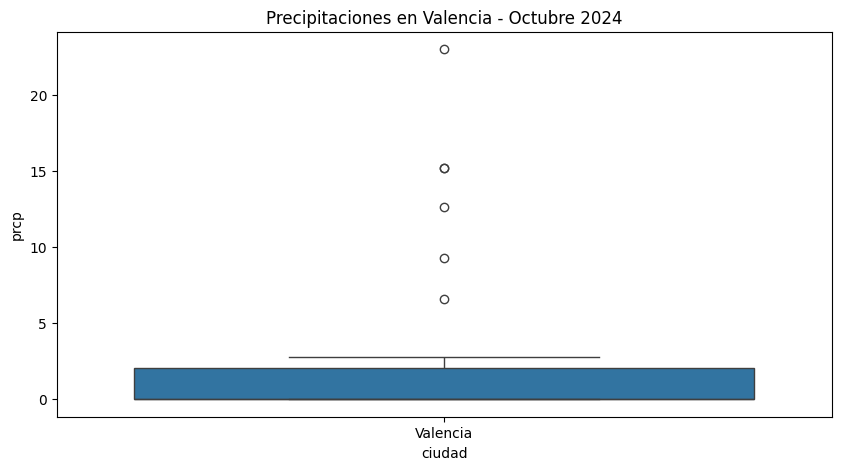

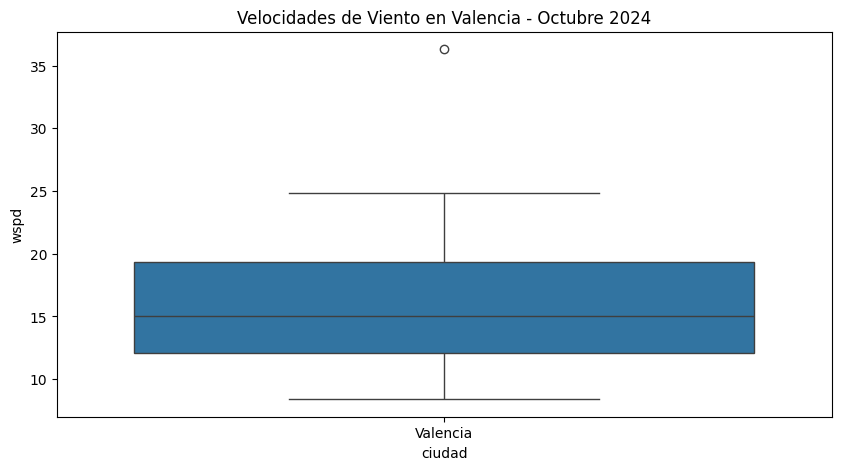

In [8]:
# Instalar librerías necesarias (ejecuta estas líneas si no las tienes)
# !pip install meteostat pandas matplotlib seaborn folium

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from datetime import datetime
from meteostat import Point, Daily
from IPython.display import display, HTML, IFrame as DisplayIFrame

# Definir la ubicación de Valencia
lat, lon = 39.4699, -0.3763

# Definir el periodo de tiempo: octubre 2024
start = datetime(2024, 10, 1)
end = datetime(2024, 10, 31)

# Obtener datos meteorológicos de Valencia
punto = Point(lat, lon)
df_valencia = Daily(punto, start, end).fetch()

# Añadir columnas con la ciudad y coordenadas
df_valencia['ciudad'] = "Valencia"
df_valencia['lat'] = lat
df_valencia['lon'] = lon

# Mostrar columnas y primeras filas
print("Columnas disponibles:", df_valencia.columns)
print(df_valencia.head())

# Definir alertas
df_valencia['emergencia_viento'] = df_valencia['wspd'] > 50    # Alerta por viento fuerte
df_valencia['emergencia_lluvia'] = df_valencia['prcp'] > 30    # Alerta por lluvia fuerte

# Gráfico de temperaturas máximas
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='tmax', data=df_valencia)
plt.title('Temperaturas Máximas en Valencia - Octubre 2024')
plt.show()

# Gráfico de precipitaciones
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='prcp', data=df_valencia)
plt.title('Precipitaciones en Valencia - Octubre 2024')
plt.show()

# Gráfico de velocidades de viento
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='wspd', data=df_valencia)
plt.title('Velocidades de Viento en Valencia - Octubre 2024')
plt.show()

# Crear mapa de alertas
m = folium.Map(location=[lat, lon], zoom_start=10)

for _, row in df_valencia.iterrows():
    # Definir color de alerta
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    # Añadir marcador circular
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"<b>Ciudad:</b> Valencia<br>"
            f"<b>Fecha:</b> {row.name.date()}<br>"
            f"<b>Temp Máx:</b> {row['tmax']}°C<br>"
            f"<b>Precipitación:</b> {row['prcp']} mm<br>"
            f"<b>Viento:</b> {row['wspd']} km/h<br>"
            f"<b>Alerta:</b> {'Viento fuerte' if row['emergencia_viento'] else 'Lluvia intensa' if row['emergencia_lluvia'] else 'Ninguna'}"
        )
    ).add_to(m)

# Guardar y mostrar mapa
m.save("mapa_alertas_valencia.html")
display(HTML('<h3>Mapa de Alertas Meteorológicas en Valencia - Octubre 2024</h3>'))
display(DisplayIFrame("mapa_alertas_valencia.html", width="100%", height="600"))


No tiene sentido, llovieron más de 770 l/m2. Es que estos datos no son fiables?

Bueno, sigo con tema visualización de alertas, me instalo iframe y repito codigo, a ver si conseguimos ver algo. Pongo valores de alerta 10 y 10. Vamos, un día normal en Albacete.

            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
2024-10-10  14.3  11.6  18.5   0.0   NaN  265.0  12.9   NaN  1012.6   NaN   
2024-10-11  13.4  10.0  19.2   6.7   NaN  119.0   9.1   NaN  1014.7   NaN   
2024-10-12  16.1  13.8  16.7  21.4   NaN  159.0  11.9   NaN  1012.5   NaN   
2024-10-13  16.5  13.6  21.2   0.0   NaN   40.0   9.5   NaN  1017.5   NaN   
2024-10-14  16.9  15.8  22.1   0.0   NaN   37.0   9.6   NaN  1015.8   NaN   

            ciudad      lat     lon  
2024-10-10  Madrid  40.4168 -3.7038  
2024-10-11  Madrid  40.4168 -3.7038  
2024-10-12  Madrid  40.4168 -3.7038  
2024-10-13  Madrid  40.4168 -3.7038  
2024-10-14  Madrid  40.4168 -3.7038  


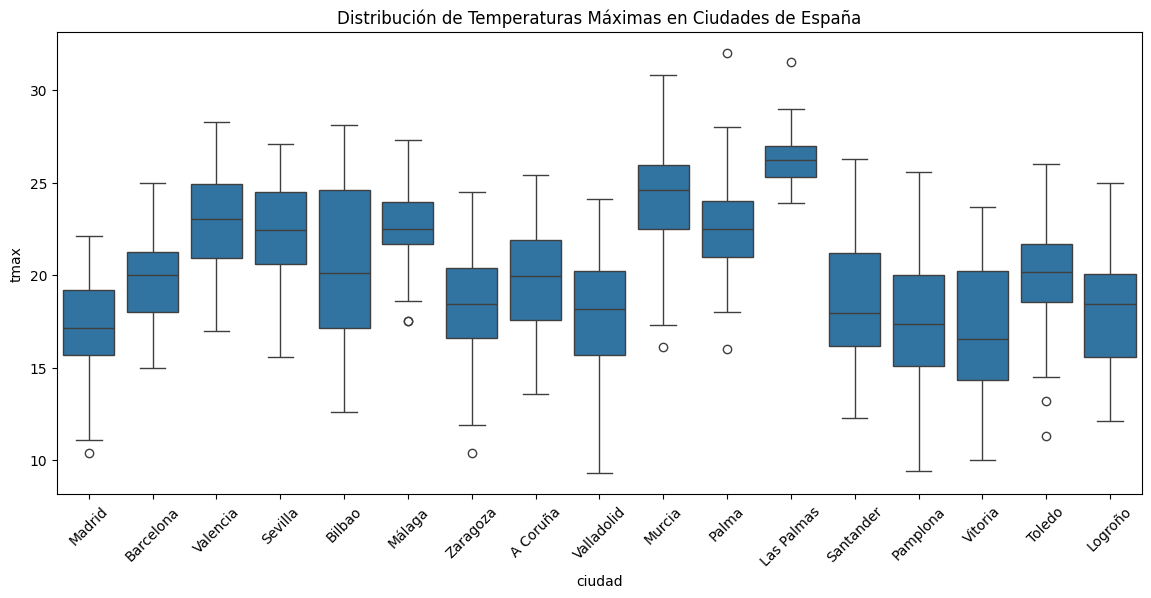

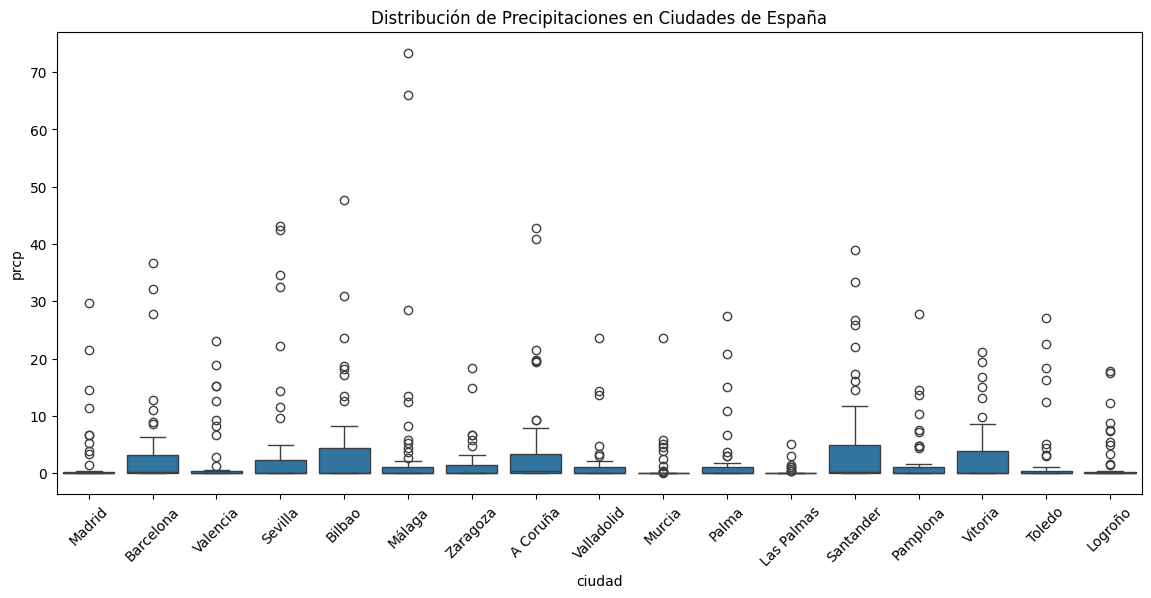

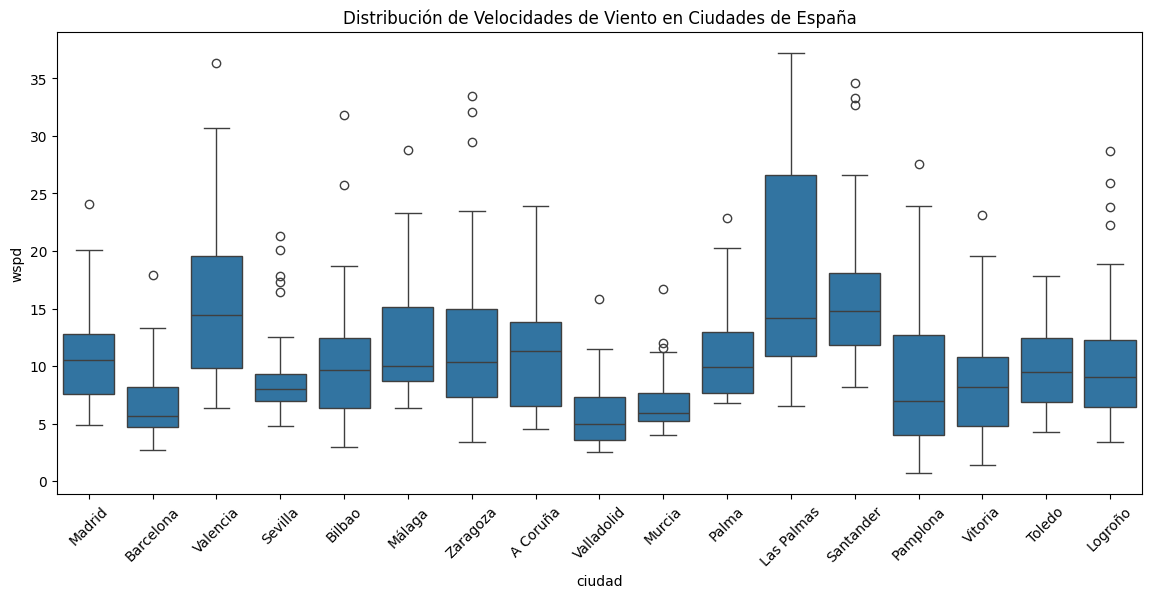

Mapa guardado como mapa_alertas_espana.html


In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime
from IPython.display import display, HTML, IFrame
from meteostat import Daily, Point

# Lista de puntos geográficos (coordenadas aproximadas de ciudades importantes)
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3874, 2.1686),
    "Valencia": (39.4699, -0.3763),
    "Sevilla": (37.3886, -5.9823),
    "Bilbao": (43.2630, -2.9340),
    "Málaga": (36.7202, -4.4203),
    "Zaragoza": (41.6488, -0.8891),
    "A Coruña": (43.3623, -8.4115),
    "Valladolid": (41.6528, -4.7245),
    "Murcia": (37.9922, -1.1307),
    "Palma": (39.5696, 2.6502),
    "Las Palmas": (28.1235, -15.4363),
    "Santa Cruz de Tenerife": (28.4636, -16.2518),
    "Santander": (43.4623, -3.8099),
    "Pamplona": (42.8125, -1.6458),
    "Vitoria": (42.8467, -2.6716),
    "Toledo": (39.8628, -4.0273),
    "Logroño": (42.4650, -2.4480)
}

# Crear DataFrame vacío para consolidar datos de toda España
df_total = pd.DataFrame()

# Definir periodo de tiempo
start = datetime(2024, 10, 10)
end = datetime(2024, 11, 26)

# Recorrer ciudades y obtener datos
for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()
    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# Mostrar datos combinados
print(df_total.head())

# Gráfico de temperaturas máximas por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='tmax', data=df_total)
plt.title('Distribución de Temperaturas Máximas en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de precipitaciones por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='prcp', data=df_total)
plt.title('Distribución de Precipitaciones en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Gráfico de velocidades de viento por ciudad
plt.figure(figsize=(14, 6))
sns.boxplot(x='ciudad', y='wspd', data=df_total)
plt.title('Distribución de Velocidades de Viento en Ciudades de España')
plt.xticks(rotation=45)
plt.show()

# Detección de alertas/emergencias
df_total['emergencia_viento'] = df_total['wspd'] > 10

# Definir alerta por lluvia fuerte
df_total['emergencia_lluvia'] = df_total['prcp'] > 10

# Crear mapa con alertas visuales
m = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

for _, row in df_total.iterrows():
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(f"Ciudad: {row['ciudad']}\nFecha: {row.name.date()}\n"
               f"Temp Max: {row['tmax']}°C\nPrecip: {row['prcp']} mm\nViento: {row['wspd']} km/h")
    ).add_to(m)

m.save("mapa_alertas_espana.html")
print("Mapa guardado como mapa_alertas_espana.html")

# Incrustar el mapa en un IFrame
display(IFrame("mapa_alertas_espana.html", width="100%", height="600"))


Voy a hacerle caso a Eva y uso STREAMLIT a ver qué pasa.

🔍 Datos meteorológicos de Valencia - Octubre 2024
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
time                                                                        
2024-10-01  20.2  17.0  26.2   0.0   NaN  324.0  11.6   NaN  1015.6   NaN   
2024-10-02  23.9  18.8  32.5   0.0   NaN  281.0  18.0   NaN  1009.3   NaN   
2024-10-03  22.2  21.2  26.8   0.0   NaN   27.0  17.6   NaN  1009.3   NaN   
2024-10-04  19.1  16.0  26.4   0.0   NaN  279.0  13.9   NaN  1013.4   NaN   
2024-10-05  19.7  15.8  27.0   0.0   NaN  332.0  13.8   NaN  1012.9   NaN   

              ciudad      lat     lon  emergencia_viento  emergencia_lluvia  
time                                                                         
2024-10-01  Valencia  39.4699 -0.3763              False              False  
2024-10-02  Valencia  39.4699 -0.3763              False              False  
2024-10-03  Valencia  39.4699 -0.3763              False              False  
2024-10-04  Valencia

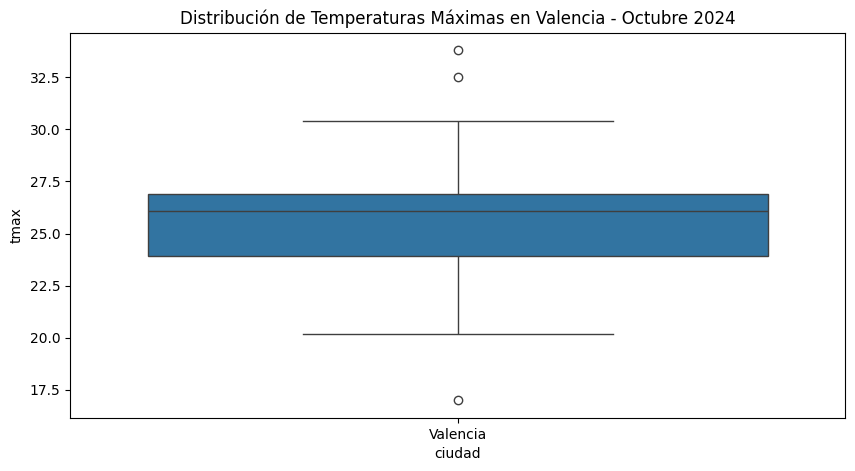

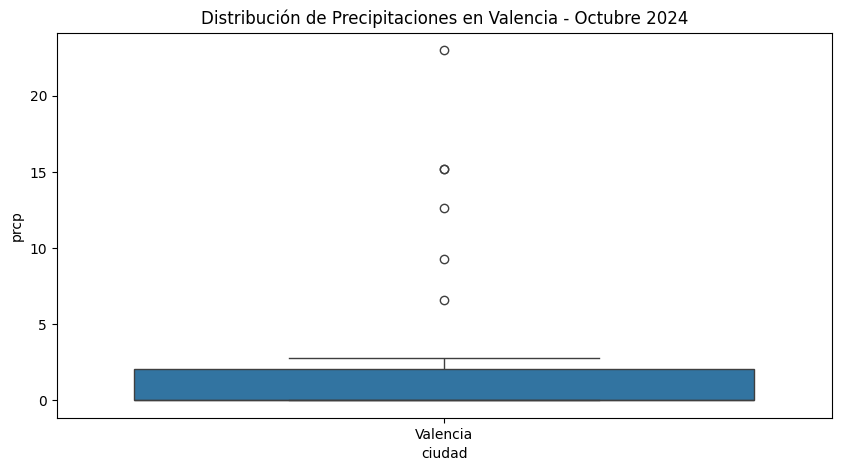

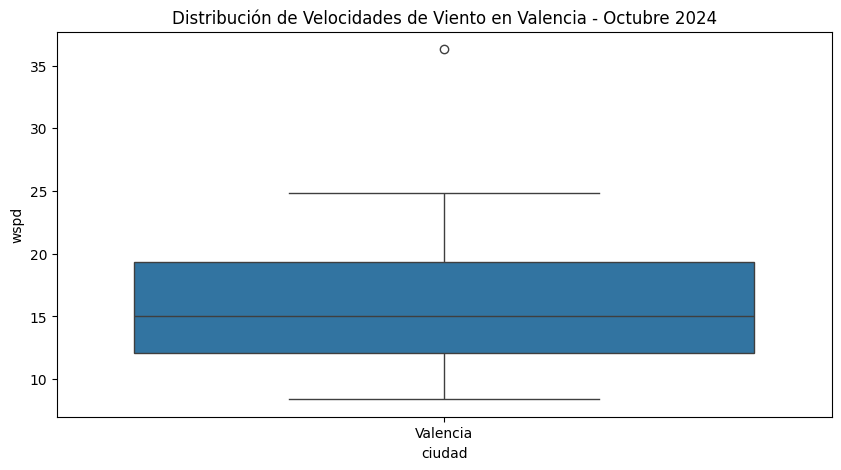

In [10]:
# ============================
# 1. INSTALAR DEPENDENCIAS
# ============================
!pip install meteostat folium pandas matplotlib seaborn

# ============================
# 2. IMPORTAR LIBRERÍAS
# ============================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from datetime import datetime
from meteostat import Point, Daily

# ============================
# 3. DESCARGAR DATOS METEOROLÓGICOS
# ============================

# Definir coordenadas de Valencia
lat, lon = 39.4699, -0.3763

# Definir periodo de tiempo
start = datetime(2024, 10, 1)
end = datetime(2024, 10, 31)

# Obtener datos de Meteostat
punto = Point(lat, lon)
df_valencia = Daily(punto, start, end).fetch()

# Añadir metadatos
df_valencia['ciudad'] = "Valencia"
df_valencia['lat'] = lat
df_valencia['lon'] = lon

# Definir alertas
df_valencia['emergencia_viento'] = df_valencia['wspd'] > 50  # Viento fuerte
df_valencia['emergencia_lluvia'] = df_valencia['prcp'] > 30  # Lluvia fuerte

# Mostrar datos
print("🔍 Datos meteorológicos de Valencia - Octubre 2024")
print(df_valencia.head())

# ============================
# 4. GRÁFICOS
# ============================

# Gráfico de temperaturas máximas
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='tmax', data=df_valencia)
plt.title('Distribución de Temperaturas Máximas en Valencia - Octubre 2024')
plt.show()

# Gráfico de precipitaciones
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='prcp', data=df_valencia)
plt.title('Distribución de Precipitaciones en Valencia - Octubre 2024')
plt.show()

# Gráfico de velocidades de viento
plt.figure(figsize=(10, 5))
sns.boxplot(x='ciudad', y='wspd', data=df_valencia)
plt.title('Distribución de Velocidades de Viento en Valencia - Octubre 2024')
plt.show()

# ============================
# 5. MAPA DE ALERTAS
# ============================

# Crear mapa de Valencia
m = folium.Map(location=[lat, lon], zoom_start=10)

# Añadir marcadores
for fecha, row in df_valencia.iterrows():
    color = "green"
    if row['emergencia_viento']:
        color = "red"
    elif row['emergencia_lluvia']:
        color = "orange"

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"Fecha: {fecha.date()}<br>"
            f"Temp Máx: {row['tmax']} °C<br>"
            f"Precipitación: {row['prcp']} mm<br>"
            f"Viento: {row['wspd']} km/h<br>"
            f"Alerta: {'Viento fuerte' if row['emergencia_viento'] else 'Lluvia intensa' if row['emergencia_lluvia'] else 'Ninguna'}"
        )
    ).add_to(m)

# Mostrar mapa (se verá directamente en Colab)
m


Bingo!Ahora queda ver porqué no hay alertas en los datos, o buscar otras bases de datos.

Voy a experimentar. Intentaré añadir aqui un código para que genere un power point con la info sobre los datos, cómo se han exportado y procesado. No sale pero no lo borro.

In [ ]:
# Primero, instala librerías necesarias (en Colab ejecuta esto solo una vez)
!pip install python-pptx meteostat folium seaborn

import pandas as pd
from datetime import datetime
from meteostat import Daily, Point
from pptx import Presentation
from pptx.util import Inches
from pptx.table import Table
from pptx.dml.color import RGBColor
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- SOLICITAR API KEY AL USUARIO ---
API_KEY = input("Introduce tu METEOSAT API Key:")
os.environ['METEOSAT_API_KEY'] = API_KEY  # Guarda la clave en variable de entorno

# --- Lista de ciudades y coordenadas ---
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3874, 2.1686),
}

# --- Definir periodo ---
start = datetime(2024, 2, 20)
end = datetime(2024, 2, 27)

# --- Descargar datos ---
df_total = pd.DataFrame()

for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()

    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# --- Transformaciones (añadir emergencias) ---
df_total['emergencia_viento'] = df_total['wspd'] > 80
df_total['emergencia_lluvia'] = df_total['prcp'] > 50

# --- Crear presentación PowerPoint ---
prs = Presentation()

# --- Slide 1: Título ---
slide_title = prs.slides.add_slide(prs.slide_layouts[0])
title = slide_title.shapes.title
title.text = "Informe: Proceso de datos Meteostat"

subtitle = slide_title.placeholders[1]
subtitle.text = "Generado automáticamente desde Python"

# --- Slide 2: Datos originales ---
slide_data_orig = prs.slides.add_slide(prs.slide_layouts[5])
title, content = slide_data_orig.shapes.title, slide_data_orig.placeholders[0]
title.text = "Datos originales (Meteostat)"
content.text = "Primera muestra de datos obtenidos desde Meteostat."

# Añadir tabla de datos originales (primeras filas)
table = slide_data_orig.shapes.add_table(rows=6, cols=len(df_total.columns), left=Inches(0.5), top=Inches(1.5), width=Inches(9), height=Inches(2)).table

# Encabezados
for col_idx, col_name in enumerate(df_total.columns):
    table.cell(0, col_idx).text = col_name

# Datos
for row_idx, row in enumerate(df_total.head(5).itertuples(index=False), start=1):
    for col_idx, value in enumerate(row):
        table.cell(row_idx, col_idx).text = str(value)

# --- Slide 3: Transformaciones ---
slide_trans = prs.slides.add_slide(prs.slide_layouts[1])
slide_trans.shapes.title.text = "Transformaciones Realizadas"
content = slide_trans.placeholders[0]
content.text = (
    "1. Añadimos las columnas:\n"
    "- emergencia_viento: Si la velocidad del viento > 80 km/h.\n"
    "- emergencia_lluvia: Si la precipitación > 50 mm.\n"
    "2. Consolidamos datos de varias ciudades en un único DataFrame."
)

# --- Slide 4: Datos transformados ---
slide_data_trans = prs.slides.add_slide(prs.slide_layouts[5])
title, content = slide_data_trans.shapes.title, slide_data_trans.placeholders[0]
title.text = "Datos transformados (con emergencias)"
content.text = "Datos después de añadir columnas de emergencia."

# Añadir tabla de datos transformados
table = slide_data_trans.shapes.add_table(rows=6, cols=len(df_total.columns), left=Inches(0.5), top=Inches(1.5), width=Inches(9), height=Inches(2)).table

# Encabezados
for col_idx, col_name in enumerate(df_total.columns):
    table.cell(0, col_idx).text = col_name

# Datos
for row_idx, row in enumerate(df_total.head(5).itertuples(index=False), start=1):
    for col_idx, value in enumerate(row):
        table.cell(row_idx, col_idx).text = str(value)

# --- Slide 5: Gráfico temperaturas máximas ---
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='ciudad', y='tmax', data=df_total, ax=ax)
plt.title('Distribución Temperaturas Máximas')
plt.xticks(rotation=45)

img_stream = BytesIO()
plt.savefig(img_stream, format='png', bbox_inches='tight')
plt.close()

slide_plot = prs.slides.add_slide(prs.slide_layouts[5])
title, content = slide_plot.shapes.title, slide_plot.placeholders[0]
title.text = "Distribución de Temperaturas Máximas"
content.text = "Comparativa de temperaturas máximas por ciudad."

pic = slide_plot.shapes.add_picture(img_stream, Inches(1), Inches(1.5), width=Inches(8))

# --- Guardar PowerPoint ---
prs.save('Informe_Meteostat.pptx')
print("Presentación guardada como 'Informe_Meteostat.pptx'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 14.6 MB/s eta 0:00:00
Introduce tu METEOSAT API Key: 757dfe0f9amsh36c67c1ce2418b0p10bfcdjsn9212c2217d5e
Presentación guardada como 'Informe_Meteostat.pptx'


Y repito la presentación con más graficos y poniendo ejemplos de Madrid y Valencia

In [ ]:
# Instalar librerías necesarias (solo en Google Colab la primera vez)
!pip install python-pptx meteostat folium seaborn

import pandas as pd
from datetime import datetime
from meteostat import Daily, Point
from pptx import Presentation
from pptx.util import Inches
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# --- SOLICITAR API KEY ---
API_KEY = input("Introduce tu METEOSAT API Key:")
os.environ['METEOSAT_API_KEY'] = API_KEY

# --- Configurar ciudades y fechas ---
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Valencia": (39.4699, -0.3763)
}
start = datetime(2024, 9, 20)
end = datetime(2024, 11, 27)

# --- Descargar datos Meteostat ---
df_total = pd.DataFrame()

for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()
    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# --- Añadir columnas de emergencias ---
df_total['emergencia_viento'] = df_total['wspd'] > 80
df_total['emergencia_lluvia'] = df_total['prcp'] > 50

# --- Crear presentación PowerPoint ---
prs = Presentation()

# Slide 1: Portada
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Informe Meteostat: Valencia y Madrid"
slide.placeholders[1].text = "Análisis y visualización de datos meteorológicos"

# Slide 2: Datos originales
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Datos originales (primeras filas)"

table = slide.shapes.add_table(rows=6, cols=len(df_total.columns), left=Inches(0.5), top=Inches(1.5), width=Inches(9), height=Inches(2)).table

for col_idx, col_name in enumerate(df_total.columns):
    table.cell(0, col_idx).text = col_name

for row_idx, row in enumerate(df_total.head(5).itertuples(index=False), start=1):
    for col_idx, value in enumerate(row):
        table.cell(row_idx, col_idx).text = str(value)

# Slide 3: Transformaciones
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Transformaciones realizadas"
slide.placeholders[0].text = (
    "- Añadidas columnas 'emergencia_viento' y 'emergencia_lluvia'\n"
    "- Consolidación de datos de Valencia y Madrid"
)

# Función para añadir gráfico al PowerPoint
def add_plot_slide(title, plot_func):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = title

    fig, ax = plt.subplots(figsize=(8, 4))
    plot_func(ax)
    img_stream = BytesIO()
    plt.savefig(img_stream, format='png', bbox_inches='tight')
    plt.close()

    slide.shapes.add_picture(img_stream, Inches(1), Inches(1.5), width=Inches(8))

# Slide 4: Temperaturas máximas
add_plot_slide("Distribución de Temperaturas Máximas",
               lambda ax: sns.boxplot(x='ciudad', y='tmax', data=df_total, ax=ax))

# Slide 5: Precipitaciones
add_plot_slide("Distribución de Precipitaciones",
               lambda ax: sns.boxplot(x='ciudad', y='prcp', data=df_total, ax=ax))

# Slide 6: Presión atmosférica
add_plot_slide("Distribución de Presión Atmosférica",
               lambda ax: sns.boxplot(x='ciudad', y='pres', data=df_total, ax=ax))

# --- Crear mapa de alertas y guardarlo como HTML ---
m = folium.Map(location=[40.4168, -3.7038], zoom_start=6)

for _, row in df_total.iterrows():
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['ciudad']} ({row.name.date()})\nTmax: {row['tmax']}°C\nPrcp: {row['prcp']} mm\nViento: {row['wspd']} km/h"
    ).add_to(m)

m.save("mapa_alertas.html")

# Slide 7: Instrucciones para el mapa
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Mapa de Alertas"
slide.placeholders[0].text = (
    "El mapa de alertas ha sido generado como un archivo HTML.\n\n"
    "Puedes descargarlo desde Colab y abrirlo en tu navegador para visualizarlo.\n\n"
    "Archivo: mapa_alertas.html\n\n"
    "Si deseas insertarlo manualmente en esta presentación, haz una captura de pantalla."
)

# Guardar presentación
prs.save('Informe_Meteostat_Valencia_Madrid.pptx')
print("Presentación guardada como 'Informe_Meteostat_Valencia_Madrid.pptx'")

# Descargar archivos en Colab
from google.colab import files
files.download('Informe_Meteostat_Valencia_Madrid.pptx')
files.download('mapa_alertas.html')


Introduce tu METEOSAT API Key: 757dfe0f9amsh36c67c1ce2418b0p10bfcdjsn9212c2217d5e
Presentación guardada como 'Informe_Meteostat_Valencia_Madrid.pptx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Voy a buscar alertas True en los datos

In [12]:
import pandas as pd
from datetime import datetime
from meteostat import Daily, Point
import os

# --- Solicitar la API Key ---
API_KEY = input("Introduce tu METEOSAT API Key:")
os.environ['METEOSAT_API_KEY'] = API_KEY

# --- Ciudades y Fechas ---
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Valencia": (39.4699, -0.3763)
}
start = datetime(2018, 2, 20)
end = datetime(2025, 2, 27)

# --- Descargar datos Meteostat ---
df_total = pd.DataFrame()

for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()
    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# --- Crear columnas de emergencias ---
df_total['emergencia_viento'] = df_total['wspd'] > 80  # Viento > 80 km/h
df_total['emergencia_lluvia'] = df_total['prcp'] > 50  # Lluvia > 50 mm

# --- Filtrar filas con alguna emergencia ---
df_alertas = df_total[(df_total['emergencia_viento'] == True) | (df_total['emergencia_lluvia'] == True)]

# --- Mostrar el resultado ---
if df_alertas.empty:
    print("No se encontraron alertas de viento o lluvia en los datos consultados.")
else:
    print("🔔 ALERTAS DETECTADAS 🔔")
    print(df_alertas[['ciudad', 'tmax', 'prcp', 'wspd', 'emergencia_viento', 'emergencia_lluvia']])



Introduce tu METEOSAT API Key: 757dfe0f9amsh36c67c1ce2418b0p10bfcdjsn9212c2217d5e
🔔 ALERTAS DETECTADAS 🔔
              ciudad  tmax   prcp  wspd  emergencia_viento  emergencia_lluvia
time                                                                         
2021-10-29    Madrid  14.8   67.7  12.1              False               True
2023-09-03    Madrid  20.9   66.5  14.9              False               True
2023-10-19    Madrid  16.7  107.8  26.0              False               True
2018-06-02  Valencia  23.8   92.8  11.2              False               True
2018-10-18  Valencia  17.6  136.0  10.6              False               True
2018-11-16  Valencia  16.5  115.3  10.2              False               True
2020-01-20  Valencia   9.2   53.5  39.8              False               True
2020-11-04  Valencia  14.8   64.5  14.7              False               True
2020-11-05  Valencia  18.5   92.8  29.7              False               True
2020-11-27  Valencia  17.4   71.5  22

Detección de alertas en Valencia y Madrid desde 2018

In [13]:
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily

# ================================
# 1. CONFIGURAR CIUDADES Y PERIODO
# ================================
ciudades = {
    'Madrid': Point(40.4168, -3.7038),
    'Valencia': Point(39.4699, -0.3763)
}

start = datetime(2018, 1, 1)
end = datetime.now()

# ================================
# 2. DESCARGAR DATOS Y DETECTAR ALERTAS
# ================================

# Umbrales de alerta
UMBRAL_LLUVIA = 30  # mm de precipitación
UMBRAL_VIENTO = 50  # km/h (Meteostat devuelve m/s, lo convertimos)

# Lista para almacenar resultados
alertas = []

for ciudad, point in ciudades.items():
    print(f"Descargando datos para {ciudad}...")

    # Descargar datos diarios
    df = Daily(point, start, end).fetch()

    # Convertir viento de m/s a km/h
    df['wspd'] = df['wspd'] * 3.6

    # Detectar alertas
    df['emergencia_lluvia'] = df['prcp'] > UMBRAL_LLUVIA
    df['emergencia_viento'] = df['wspd'] > UMBRAL_VIENTO

    # Añadir ciudad
    df['ciudad'] = ciudad

    # Guardar alertas detectadas
    alertas.append(df.reset_index())

# Unir datos de todas las ciudades
df_alertas = pd.concat(alertas)

# ================================
# 3. FILTRAR SOLO DÍAS CON ALERTAS
# ================================
df_alertas = df_alertas[
    (df_alertas['emergencia_lluvia'] | df_alertas['emergencia_viento'])
]

# ================================
# 4. RESULTADO FINAL
# ================================
print(f"\n✅ Total alertas detectadas: {len(df_alertas)}")
print(df_alertas[['time', 'ciudad', 'tmax', 'prcp', 'wspd', 'emergencia_lluvia', 'emergencia_viento']])

# Guardar en CSV por si lo necesitas
df_alertas.to_csv('alertas_madrid_valencia_2018_ahora.csv', index=False)



Descargando datos para Madrid...
Descargando datos para Valencia...

✅ Total alertas detectadas: 1203
           time    ciudad  tmax  prcp    wspd  emergencia_lluvia  \
717  2019-12-19    Madrid  12.3  38.4     NaN               True   
835  2020-04-15    Madrid  15.3  18.1   50.40              False   
836  2020-04-16    Madrid  18.7   3.5   51.84              False   
847  2020-04-27    Madrid  17.3   0.0   59.40              False   
848  2020-04-28    Madrid  17.6   0.0   53.64              False   
...         ...       ...   ...   ...     ...                ...   
2611 2025-02-24  Valencia  21.0   0.0   50.40              False   
2612 2025-02-25  Valencia  18.8   1.1   70.56              False   
2616 2025-03-01  Valencia  14.1   1.4   95.76              False   
2617 2025-03-02  Valencia  12.8   7.0  110.52              False   
2618 2025-03-03  Valencia  13.6  16.0  100.44              False   

      emergencia_viento  
717               False  
835                True  
836

In [14]:
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily

# ================================
# 1. CONFIGURAR CIUDADES Y PERIODO
# ================================
ciudades = {
    'Madrid': Point(40.4168, -3.7038),
    'Valencia': Point(39.4699, -0.3763)
}

start = datetime(2018, 1, 1)
end = datetime.now()

# ================================
# 2. DESCARGAR DATOS Y DETECTAR ALERTAS
# ================================

# Umbrales de alerta
UMBRAL_LLUVIA = 30  # mm de precipitación
UMBRAL_VIENTO = 50  # km/h (Meteostat devuelve m/s, lo convertimos)

# Lista para almacenar resultados
alertas = []

for ciudad, point in ciudades.items():
    print(f"Descargando datos para {ciudad}...")

    # Descargar datos diarios
    df = Daily(point, start, end).fetch()

    # Convertir viento de m/s a km/h
    df['wspd'] = df['wspd'] * 3.6

    # Detectar alertas
    df['emergencia_lluvia'] = df['prcp'] > UMBRAL_LLUVIA
    df['emergencia_viento'] = df['wspd'] > UMBRAL_VIENTO

    # Añadir ciudad
    df['ciudad'] = ciudad

    # Guardar alertas detectadas
    alertas.append(df.reset_index())

# Unir datos de todas las ciudades
df_alertas = pd.concat(alertas)

# ================================
# 3. FILTRAR SOLO DÍAS CON ALERTAS
# ================================
df_alertas = df_alertas[
    (df_alertas['emergencia_lluvia'] | df_alertas['emergencia_viento'])
]

# ================================
# 4. RESULTADO FINAL
# ================================
print(f"\n✅ Total alertas detectadas: {len(df_alertas)}")
print(df_alertas[['time', 'ciudad', 'tmax', 'prcp', 'wspd', 'emergencia_lluvia', 'emergencia_viento']])

# Guardar en CSV por si lo necesitas
df_alertas.to_csv('alertas_madrid_valencia_2018_ahora.csv', index=False)



Descargando datos para Madrid...
Descargando datos para Valencia...

✅ Total alertas detectadas: 1203
           time    ciudad  tmax  prcp    wspd  emergencia_lluvia  \
717  2019-12-19    Madrid  12.3  38.4     NaN               True   
835  2020-04-15    Madrid  15.3  18.1   50.40              False   
836  2020-04-16    Madrid  18.7   3.5   51.84              False   
847  2020-04-27    Madrid  17.3   0.0   59.40              False   
848  2020-04-28    Madrid  17.6   0.0   53.64              False   
...         ...       ...   ...   ...     ...                ...   
2611 2025-02-24  Valencia  21.0   0.0   50.40              False   
2612 2025-02-25  Valencia  18.8   1.1   70.56              False   
2616 2025-03-01  Valencia  14.1   1.4   95.76              False   
2617 2025-03-02  Valencia  12.8   7.0  110.52              False   
2618 2025-03-03  Valencia  13.6  16.0  100.44              False   

      emergencia_viento  
717               False  
835                True  
836

In [15]:
# ============================
# 1. INSTALAR DEPENDENCIAS
# ============================
!pip install meteostat pandas folium matplotlib seaborn

# ============================
# 2. IMPORTAR LIBRERÍAS
# ============================
import pandas as pd
from meteostat import Point, Daily
from datetime import datetime
import folium

# ============================
# 3. CONFIGURAR PERÍODO Y CIUDADES
# ============================
start = datetime(2018, 1, 1)
end = datetime.today()

# Lista de ciudades con coordenadas
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Valencia": (39.4699, -0.3763)
}

# ============================
# 4. DESCARGAR DATOS Y DETECTAR LLUVIAS EXTREMAS
# ============================

# DataFrame vacío para guardar resultados
df_lluvias_extremas = pd.DataFrame()

for ciudad, (lat, lon) in ciudades.items():
    print(f"📡 Descargando datos de {ciudad}...")

    # Definir punto y descargar datos
    punto = Point(lat, lon)
    df = Daily(punto, start, end).fetch()

    # Añadir metadatos
    df['ciudad'] = ciudad
    df['lat'] = lat
    df['lon'] = lon

    # Filtrar solo días con más de 100 mm de precipitación
    df_extrema = df[df['prcp'] > 100]

    # Añadir al DataFrame final
    df_lluvias_extremas = pd.concat([df_lluvias_extremas, df_extrema])

# ============================
# 5. MOSTRAR RESULTADOS
# ============================
if df_lluvias_extremas.empty:
    print("✅ No se detectaron lluvias extremas (>100 mm) desde 2018 hasta hoy.")
else:
    df_lluvias_extremas = df_lluvias_extremas.reset_index()
    df_lluvias_extremas = df_lluvias_extremas[['time', 'ciudad', 'prcp', 'lat', 'lon']]

    print(f"🌧️ Total de días con lluvias extremas detectados: {len(df_lluvias_extremas)}")
    print(df_lluvias_extremas)

    # ============================
    # 6. MAPA DE LLUVIAS EXTREMAS
    # ============================

    mapa = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

    for _, row in df_lluvias_extremas.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=10,
            color='blue',
            fill=True,
            fill_opacity=0.7,
            popup=(
                f"Ciudad: {row['ciudad']}<br>"
                f"Fecha: {row['time'].date()}<br>"
                f"Precipitación: {row['prcp']} mm"
            )
        ).add_to(mapa)

    # Guardar mapa
    mapa.save("lluvias_extremas_espana.html")
    print("🌍 Mapa guardado como 'lluvias_extremas_espana.html'")

    # Mostrar preview del mapa (en Colab)
    from IPython.display import display, HTML
    display(HTML('<iframe src="lluvias_extremas_espana.html" width="100%" height="600"></iframe>'))

# FIN


📡 Descargando datos de Madrid...
📡 Descargando datos de Valencia...
🌧️ Total de días con lluvias extremas detectados: 4
        time    ciudad   prcp      lat     lon
0 2023-10-19    Madrid  107.8  40.4168 -3.7038
1 2018-10-18  Valencia  136.0  39.4699 -0.3763
2 2018-11-16  Valencia  115.3  39.4699 -0.3763
3 2022-05-03  Valencia  172.4  39.4699 -0.3763
🌍 Mapa guardado como 'lluvias_extremas_espana.html'


In [ ]:
# Instalar librerías necesarias (solo en Google Colab la primera vez)
!pip install python-pptx meteostat folium seaborn

import pandas as pd
from datetime import datetime
from meteostat import Daily, Point
from pptx import Presentation
from pptx.util import Inches
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display
import os

# --- SOLICITAR API KEY ---
API_KEY = input("Introduce tu METEOSAT API Key:")
os.environ['METEOSAT_API_KEY'] = API_KEY

# --- Configurar ciudades y fechas ---
ciudades = {
    "Madrid": (40.4168, -3.7038),
    "Valencia": (39.4699, -0.3763)
}
start = datetime(2024, 10, 2)
end = datetime(2024, 11, 27)

# --- Descargar datos Meteostat ---
df_total = pd.DataFrame()

for ciudad, coords in ciudades.items():
    point = Point(coords[0], coords[1])
    data = Daily(point, start, end).fetch()
    data['ciudad'] = ciudad
    data['lat'] = coords[0]
    data['lon'] = coords[1]
    df_total = pd.concat([df_total, data])

# --- Añadir columnas de emergencias ---
df_total['emergencia_viento'] = df_total['wspd'] > 80
df_total['emergencia_lluvia'] = df_total['prcp'] > 50

# --- Crear presentación PowerPoint ---
prs = Presentation()

# Slide 1: Portada
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Informe Meteostat: Valencia y Madrid"
slide.placeholders[1].text = "Análisis y visualización de datos meteorológicos"

# Slide 2: Datos originales
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Datos originales (primeras filas)"

table = slide.shapes.add_table(rows=6, cols=len(df_total.columns), left=Inches(0.5), top=Inches(1.5), width=Inches(9), height=Inches(2)).table

for col_idx, col_name in enumerate(df_total.columns):
    table.cell(0, col_idx).text = col_name

for row_idx, row in enumerate(df_total.head(5).itertuples(index=False), start=1):
    for col_idx, value in enumerate(row):
        table.cell(row_idx, col_idx).text = str(value)

# Slide 3: Transformaciones
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Transformaciones realizadas"
slide.placeholders[0].text = (
    "- Añadidas columnas 'emergencia_viento' y 'emergencia_lluvia'\n"
    "- Consolidación de datos de Valencia y Madrid"
)

# Función para añadir gráfico al PowerPoint
def add_plot_slide(title, plot_func):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = title

    fig, ax = plt.subplots(figsize=(8, 4))
    plot_func(ax)
    img_stream = BytesIO()
    plt.savefig(img_stream, format='png', bbox_inches='tight')
    plt.close()

    slide.shapes.add_picture(img_stream, Inches(1), Inches(1.5), width=Inches(8))

# Slide 4: Temperaturas máximas
add_plot_slide("Distribución de Temperaturas Máximas",
               lambda ax: sns.boxplot(x='ciudad', y='tmax', data=df_total, ax=ax))

# Slide 5: Precipitaciones
add_plot_slide("Distribución de Precipitaciones",
               lambda ax: sns.boxplot(x='ciudad', y='prcp', data=df_total, ax=ax))

# Slide 6: Presión atmosférica
add_plot_slide("Distribución de Presión Atmosférica",
               lambda ax: sns.boxplot(x='ciudad', y='pres', data=df_total, ax=ax))

# --- Crear mapa de alertas ---
m = folium.Map(location=[40.4168, -3.7038], zoom_start=6)

for _, row in df_total.iterrows():
    color = 'green'
    if row['emergencia_viento']:
        color = 'red'
    elif row['emergencia_lluvia']:
        color = 'orange'

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['ciudad']} ({row.name.date()})\nTmax: {row['tmax']}°C\nPrcp: {row['prcp']} mm\nViento: {row['wspd']} km/h"
    ).add_to(m)

mapa_filename = "mapa_alertas.png"
m.save("mapa_alertas.html")

# Convertir HTML de mapa a PNG (usamos captura de pantalla en Colab)
from selenium import webdriver
from PIL import Image

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=options)
driver.set_window_size(800, 600)
driver.get('file://' + os.getcwd() + '/mapa_alertas.html')
driver.save_screenshot(mapa_filename)
driver.quit()

# Slide 7: Mapa de alertas
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Mapa de Alertas (viento y lluvia)"
slide.shapes.add_picture(mapa_filename, Inches(1), Inches(1.5), width=Inches(8))

# Guardar presentación
prs.save('Informe_Meteostat_Valencia_Madrid.pptx')
print("Presentación guardada como 'Informe_Meteostat_Valencia_Madrid.pptx'")

# Descargar en Colab
from google.colab import files
files.download('Informe_Meteostat_Valencia_Madrid.pptx')


Introduce tu METEOSAT API Key: 757dfe0f9amsh36c67c1ce2418b0p10bfcdjsn9212c2217d5e


ModuleNotFoundError: No module named 'selenium'

Y ahora voy a ver si soy capaz de hacer tablas con los datos que meta un usuario en un interfaz

Tengo otro codigo para generar las alertas aqui: http://127.0.0.1:5000/mapa_alertas. Pero lo he borrado de este colab.